# <font color='violet'> Deeper EDA on Review Text, Begin Feature Engineering

On data that was cleaned and lemmatized here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/4-kl-studies-nlp.ipynb

In [13]:
# ! pip install nltk
# nltk.download('punkt')

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import re
from textblob import TextBlob

from IPython.display import Audio
sound_file = './alert.wav'

In [3]:
df = pd.read_csv('../data/interim/studies_lemmatized.csv').drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rating         31559 non-null  float64
 1   condition      31559 non-null  object 
 2   review         31559 non-null  object 
 3   date           31451 non-null  object 
 4   drug0          31559 non-null  object 
 5   drug1          18992 non-null  object 
 6   drug2          32 non-null     object 
 7   drug3          23 non-null     object 
 8   drug4          12 non-null     object 
 9   drug5          11 non-null     object 
 10  drug6          7 non-null      object 
 11  drug7          5 non-null      object 
 12  drug8          3 non-null      object 
 13  drug9          2 non-null      object 
 14  drug10         2 non-null      object 
 15  drug11         2 non-null      object 
 16  drug12         2 non-null      object 
 17  drug13         2 non-null      object 
 18  drug14

<font color='violet'> How do the lengths compare for the review strings with just punctuation removed vs. the lemmatized strings?

In [4]:
df.review_len.mean()

473.5181406254951

In [5]:
df['lemm_len'] = [len(df.loc[row,'no_stops_lemm']) for row in range(len(df))]
df.lemm_len.mean()

250.39069679013912

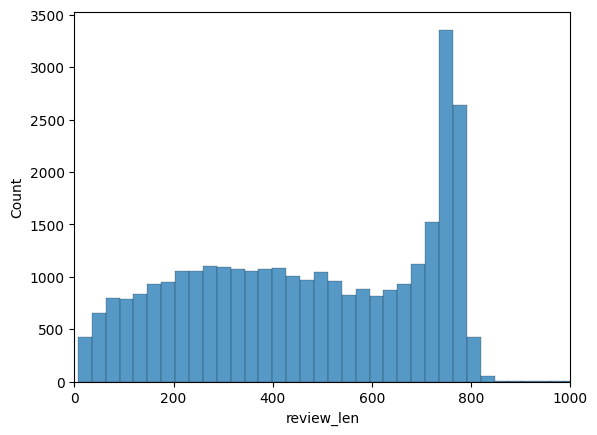

In [7]:
# Plot the distribution of review lengths. There are some outliers; zoom in a bit. 
sns.histplot(df.review_len).set(xlim=(0,1000))
plt.show()

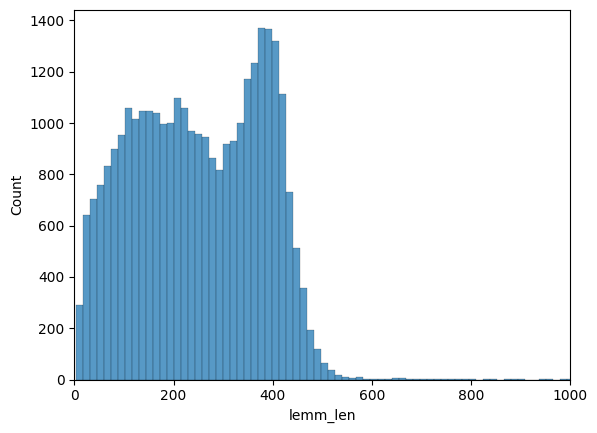

In [9]:
# Did lemmatizing and removing stopwords do anything to normalize the distribution of lengths?
sns.histplot(df.lemm_len).set(xlim=(0,1000))
plt.show()

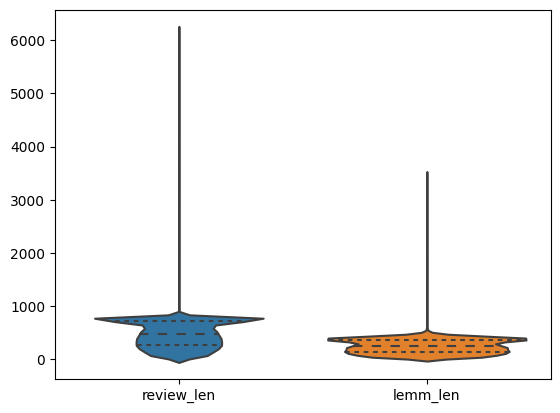

In [10]:
# The second peak looks a bit less extreme. Compare distributions of lengths side by side. 
sns.violinplot(df[['review_len', 'lemm_len']], inner='quartile')
plt.show()

Average complexity of perfect reviews appears to be very slightly lower, but my impression is that text complexity doesn't vary greatly by rating. 

Use the lemmatized text for this in order to draw from a smaller, more normalized set of words. 

In [15]:
# Get counter of words and find the most frequent.
word_counter = Counter(word_tokenize(' '.join(df['no_stops_lemm'].tolist())))
most_common_words = dict(word_counter.most_common(20))
most_common_words

{'take': 21116,
 'feel': 20419,
 'day': 18189,
 'anxiety': 14920,
 'year': 14866,
 '!': 14544,
 'work': 14008,
 'effect': 12675,
 'start': 11942,
 'sleep': 11740,
 'week': 11416,
 'mg': 10912,
 'help': 10653,
 'time': 10257,
 'month': 9913,
 'like': 9853,
 'go': 9570,
 'life': 9332,
 'meditation': 9250,
 'depression': 9075}

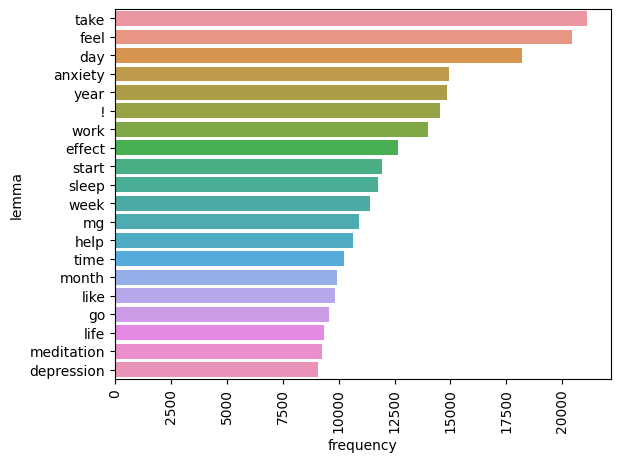

In [16]:
# What is the relative distribution of these strings across lemmatized reviews?
most_common_words_df = pd.DataFrame(data = most_common_words.items(), 
                                     columns=['lemma', 'frequency'])
sns.barplot(data=most_common_words_df, x='frequency', y='lemma')
plt.xticks(rotation=90)
plt.show()

In [17]:
# Get bigrams. This will be easiest if I first remove excessive spaces between lemmas.
for row in tqdm(range(len(df))):
    string_to_strip = df.loc[row, 'no_stops_lemm']
    stripped = " ".join(string_to_strip.split())
    df.loc[row,'no_stops_lemm'] = stripped
    
# Check to see if this worked
len(df[df.no_stops_lemm.str.find('  ')!=-1])

100%|██████████| 31559/31559 [00:20<00:00, 1519.78it/s]


0

In [18]:
list_of_strings = df['no_stops_lemm'].tolist()
bigrams = [x for y in list_of_strings for x in zip(y.split(" ")[:-1], y.split(" ")[1:])]
len(bigrams)

1184750

In [19]:
bigrams[0:5]

[('begin', 'take'),
 ('take', '20'),
 ('20', 'mg'),
 ('mg', 'Vyvanse'),
 ('Vyvanse', 'month')]

In [20]:
# Use counter to find most common bigrams. 
bigram_counter = Counter(bigrams)
most_common_bigrams = dict(bigram_counter.most_common(20))
most_common_bigrams

{('feel', 'like'): 3827,
 ('panic', 'attack'): 3288,
 ('!', '!'): 2816,
 ('start', 'take'): 2104,
 ('10', 'mg'): 1536,
 ('weight', 'gain'): 1531,
 ('year', 'ago'): 1495,
 ('fall', 'asleep'): 1346,
 ('20', 'mg'): 1323,
 ('2', 'week'): 1299,
 ('stop', 'take'): 1179,
 ('much', 'well'): 1153,
 ('year', 'old'): 1145,
 ('no', 'effect'): 1145,
 ('50', 'mg'): 1142,
 ('feel', 'well'): 1138,
 ('depression', 'anxiety'): 1034,
 ('first', 'week'): 970,
 ('work', 'great'): 947,
 ('no', 'long'): 946}

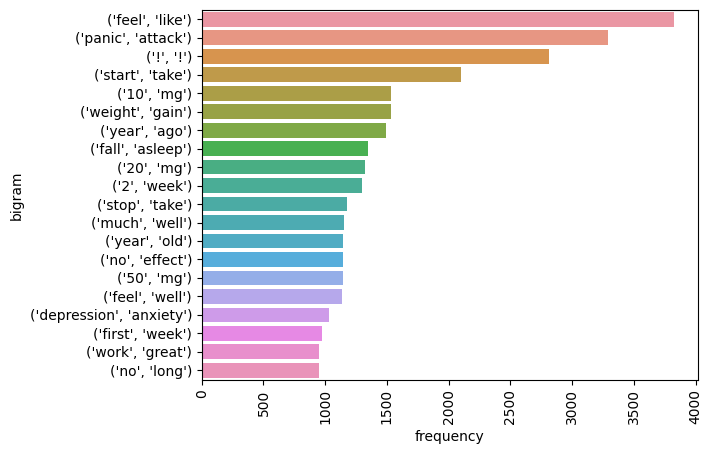

In [21]:
# Visualize bigrams
most_common_bigrams_df = pd.DataFrame(data = most_common_bigrams.items(), 
                                     columns=['bigram', 'frequency'])
sns.barplot(data=most_common_bigrams_df, x='frequency', y='bigram')
plt.xticks(rotation=90)
plt.show()

Some of these are just quantities, but some definitely seem associated with sentiments. See if trigrams seem to be a worthwile thing to build into eventual feature engineering 

In [22]:
trigrams = []

for row in tqdm(range(len(df))):
    string_to_work_w = df.loc[row, 'no_stops_lemm']
    words_list = string_to_work_w.split(" ")
    these_trigrams = []
    for i in range(0 , len(words_list) - 2):
        trigram = words_list[i] + " " + words_list[i+1] + " " + words_list[i + 2]
        these_trigrams.append(trigram)
    trigrams += these_trigrams

len(trigrams)

100%|██████████| 31559/31559 [00:00<00:00, 31756.46it/s]


1153318

In [23]:
trigrams[:5]

['begin take 20',
 'take 20 mg',
 '20 mg Vyvanse',
 'mg Vyvanse month',
 'Vyvanse month surprised']

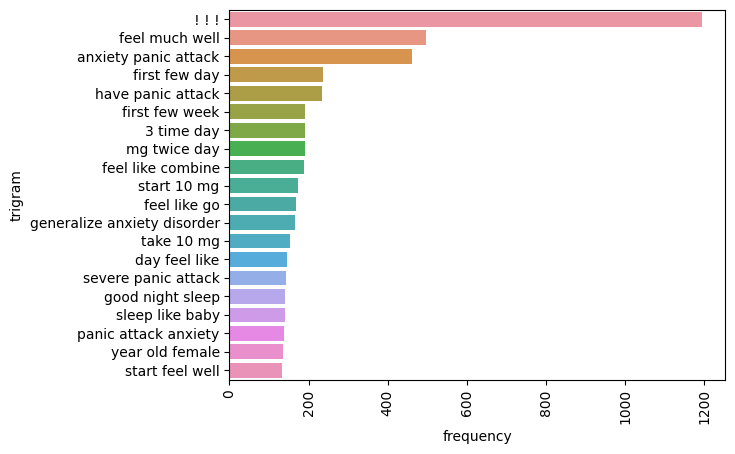

In [24]:
# Get counter for trigrams & Visualize
trigrams_counter = Counter(trigrams)
most_common_trigrams = dict(trigrams_counter.most_common(20))

most_common_trigrams_df = pd.DataFrame(data = most_common_trigrams.items(), 
                                     columns=['trigram', 'frequency'])
sns.barplot(data=most_common_trigrams_df, x='frequency', y='trigram')
plt.xticks(rotation=90)
plt.show()

100%|██████████| 31559/31559 [00:01<00:00, 29310.83it/s]


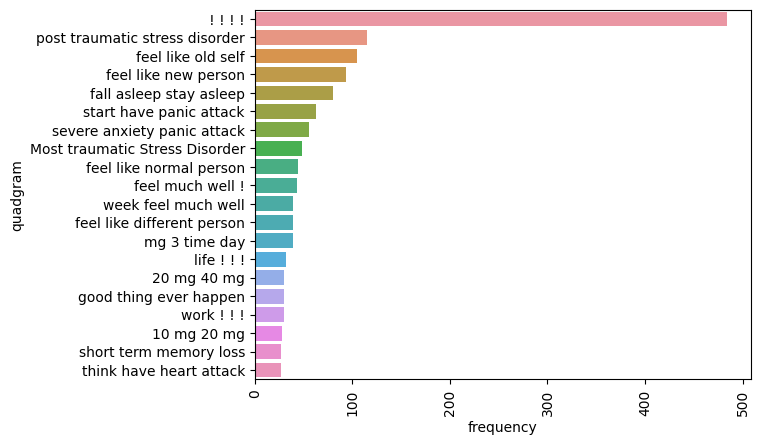

In [25]:
# Fascinating. Repeat for quadgrams
quadgrams = []

for row in tqdm(range(len(df))):
    string_to_work_w = df.loc[row, 'no_stops_lemm']
    words_list = string_to_work_w.split(" ")
    these_quadgrams = []
    for i in range(0 , len(words_list) - 3):
        quadgram = (words_list[i] + " " + words_list[i+1] + " " + words_list[i + 2] + " " + 
                    words_list[i + 3])
        these_quadgrams.append(quadgram)
    quadgrams += these_quadgrams

# Get counter and visualize
quadgrams_counter = Counter(quadgrams)
most_common_quadgrams = dict(quadgrams_counter.most_common(20))

most_common_quadgrams_df = pd.DataFrame(data = most_common_quadgrams.items(), 
                                     columns=['quadgram', 'frequency'])
sns.barplot(data=most_common_quadgrams_df, x='frequency', y='quadgram')
plt.xticks(rotation=90)
plt.show()

100%|██████████| 31559/31559 [00:01<00:00, 24262.70it/s]


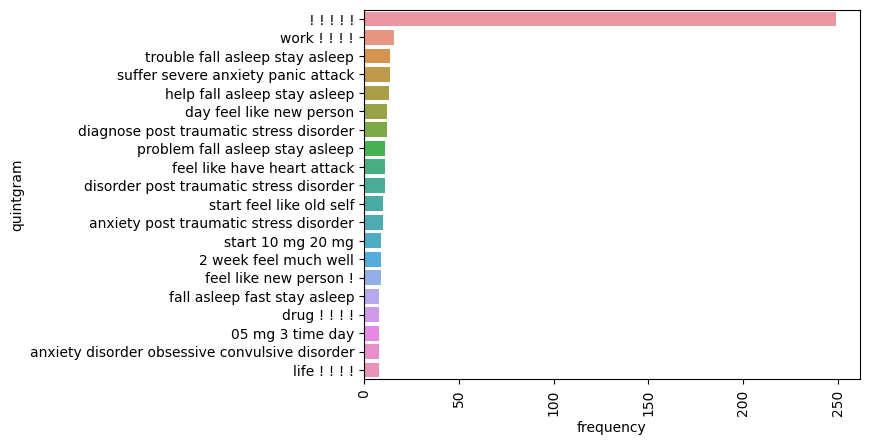

In [26]:
# And quintgrams
quintgrams = []

for row in tqdm(range(len(df))):
    string_to_work_w = df.loc[row, 'no_stops_lemm']
    words_list = string_to_work_w.split(" ")
    these_quintgrams = []
    for i in range(0 , len(words_list) - 4):
        quintgram = (words_list[i] + " " + words_list[i+1] + " " + words_list[i + 2] + " " + 
                     words_list[i + 3] + " " + words_list[i + 4])
        these_quintgrams.append(quintgram)
    quintgrams += these_quintgrams

# Get counter and visualize
quintgrams_counter = Counter(quintgrams)
most_common_quintgrams = dict(quintgrams_counter.most_common(20))

most_common_quintgrams_df = pd.DataFrame(data = most_common_quintgrams.items(), 
                                     columns=['quintgram', 'frequency'])
sns.barplot(data=most_common_quintgrams_df, x='frequency', y='quintgram')
plt.xticks(rotation=90)
plt.show()

In [27]:
# Lol, purely out of curiosity, what's the greatest number of ! somebody used in a row
df[df.no_stops_lemm.str.find('!!!!!!')!=-1] # 6 !

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug11,drug12,drug13,drug14,drug15,review_len,complexity,spell_corr,no_stops_lemm,lemm_len
9255,7.0,addiction,I want to let everyone know about how I reacte...,2016-08-28,varenicline,chantix,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,763,4.1,I want to let everyone know about how I reacte...,want let everyone know react chantexday 7 8 so...,364


In [28]:
df[df.no_stops_lemm.str.find('!!!!!!!')!=-1] # 7 !

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug11,drug12,drug13,drug14,drug15,review_len,complexity,spell_corr,no_stops_lemm,lemm_len


The quintgram stopped revealing anything additional of much interest as far as I'm concerned. Seeing the distrubuion of the tri- and quad-grams, though, is super interesting. Of course, ngrams with large values of n lead to overfitting if used as features during modeling. And overfitting is definitely something I want to avoid since I'll want to apply this model to new data that may have fairly different sorts of words than this dataset. But it doesn't seem impossible that any narrative about any drug might contain the phrase "feel like old self" and that the phrase could be correlated with sentiment. So I'll need to play around with ngrams some more and decide what role they should play in my eventual model. 

There are some interesting trends to notice through all this and questions that arise. For example, is the model going to find it helpful to distinguish between 3 !!!, 4 !!!! and 5 !!!!!? Or are those likely expressing something very similar in terms of sentiment and better reduced down to just 3 !!! in order to reduce noise? Dig into these ngram visualizations further as I get into feature engineering. 

<font color='violet'> Are there rare but potentially important words? 

In [29]:
least_common_lemmas = word_counter.most_common()[-20:-1]
least_common_lemmas

[('sleepinessyawne', 1),
 ('nonsleep', 1),
 ('placespeople', 1),
 ('naturaldiethormonal', 1),
 ('Marie', 1),
 ('Lauriequot', 1),
 ('appetitewhich', 1),
 ('quotsetquot', 1),
 ('County', 1),
 ('Rounded', 1),
 ('daydreamnightmare', 1),
 ('defer', 1),
 ('partake', 1),
 ('depressionmania', 1),
 ('Sacrifice', 1),
 ('staircase', 1),
 ('Discontinued', 1),
 ('60mgsday', 1),
 ('MidOctober', 1)]

It looks like some of the least common words are what one would always expect, simply words that make sense for people to use, but rarely. Others are misspelled words missed by the corrector because they're especially odd, or they're words that are squished together without a space. For the latter, I'm not too worried about words like this that appear rarely. But I would like to check on words that are still misspelled if they actually appear multiple times.

I keep coming across areas where either I wish I'd replaced symbols with spaces but didn't, or wish I'd not but did. Here, I'm guessing that if some symbol had been replaced with a space, some of these incorrectly-compounded words wouldn't have been created. This is an area of growth for me where I want to learn more about the best way to deal with symbols in my strings during NLP. I could hypothetically go back and do my symbol deletion differently, but for now just see if there are any glaringly common words whose form could be improved upon.  

<font color='violet'> Deal with remaining misspelled words. 

In [37]:
# Find misspelled lemmas
misspelled = []
for row in tqdm(range(len(df))):
    str_to_check = df.loc[row,'no_stops_lemm']
    spell = SpellChecker()
    misspelled_here = list(spell.unknown(str_to_check.split(' ')))
    misspelled += misspelled_here
len(misspelled)

100%|██████████| 31559/31559 [42:52<00:00, 12.27it/s]  


55274

In [44]:
misspelled[0:20]

['moodswing',
 'vyvanse',
 'mg',
 'stabalize',
 'dexerine',
 'dextroamphetamine',
 'dexedrine',
 'vyvanse',
 'cocain',
 'abdoman',
 'somatropin',
 'diseaselewy',
 'zyprexa',
 'vyvanse',
 'fidgeted',
 'straterra',
 'strattera',
 'alot',
 ';)',
 'deppresant']

In [41]:
Audio(sound_file, autoplay=True)

In [43]:
# That took a while, store the value so I can restart the kernel later
%store misspelled

Stored 'misspelled' (list)


In [49]:
# Get the most common words from this list
misspell_counter = Counter(misspelled)
most_common_misspelling = dict(misspell_counter.most_common(90))
most_common_misspelling

{'mg': 7107,
 'lexapro': 1787,
 'wellbutrin': 1155,
 'klonopin': 779,
 'cymbalta': 732,
 'seroquel': 724,
 'ssri': 698,
 'chantix': 617,
 'lamictal': 616,
 'pristiq': 609,
 'x': 584,
 'suboxone': 547,
 'citalopram': 541,
 'sertraline': 515,
 'trazodone': 486,
 'caseous': 447,
 'ptsd': 446,
 'benzol': 368,
 'th': 364,
 'mrs': 361,
 'viibryd': 348,
 'pm': 339,
 'latuda': 337,
 'st': 333,
 'mirtazapine': 309,
 'gabapentin': 305,
 'lunesta': 278,
 'rd': 260,
 'bupropion': 251,
 'zyprexa': 241,
 'fluoxetine': 237,
 ':)': 230,
 'depakote': 224,
 'escitalopram': 221,
 'venlafaxine': 220,
 'trazadone': 218,
 'adhd': 216,
 'brintellix': 213,
 'dr': 209,
 'sideeffect': 205,
 'afternoon': 203,
 'clonidine': 185,
 'quotnormalquot': 183,
 'saphris': 183,
 'hanover': 179,
 'lamotrigine': 164,
 'quetiapine': 160,
 'fibromyalgia': 154,
 'sycosis': 153,
 'adduct': 152,
 'pmdd': 150,
 'll': 143,
 'risperdal': 143,
 'tramadol': 142,
 'belsomra': 142,
 'palpitate': 138,
 'champix': 127,
 'buspirone': 127,

There aren't actually many words in here that aren't just drug names, conditions, etc. Pull out those few that are needing to be fixed and replace them where they exist within the column. For a few of the words, I'd like to check out where they appear in context to make sure I'm changing them in a way that makes sense. Some words I might just change to match 

In [54]:
df[df['no_stops_lemm'].str.find('hanover')!=-1]['no_stops_lemm'].head()

332     brain injury sleep 2 3 hour night doxepin 10 f...
827                work great 1000 mg hanover solid sleep
1182    extreme anxiety disorder 25 mg alone knock hou...
1334    10 mg Lexapro 3 day really dizzy eye open 2 aw...
1339    admit first prescribe meditation resistant lik...
Name: no_stops_lemm, dtype: object

In [55]:
df.no_stops_lemm[332]

'brain injury sleep 2 3 hour night doxepin 10 find capsule dump 5 medicine sleep 6 7 hour wake feel great hanover wake night sleep drug wonderful correctly'

In [68]:
misspelling_replacements = {'dr':'doctor', 'sideeffect':'side effect', 'hanover':'hangover',
                            'anxietypanic':'anxiety panic', 
                            'anxietydepression':'anxiety depression','caffein':'caffeine',
                            'depressionanxiety':'depression anxiety', 'ssris':'ssri'}

for row in tqdm(range(len(df))):
    str_to_replace_misspelling = df.loc[row,'no_stops_lemm']
    for key, value in misspelling_replacements.items():
        str_to_replace_misspelling = str_to_replace_misspelling.replace(key,value)
    df.loc[row,'no_stops_lemm'] = str_to_replace_misspelling
        
df.no_stops_lemm[332]

100%|██████████| 31559/31559 [00:04<00:00, 7846.82it/s]


'brain injury sleep 2 3 hour night doxepin 10 find capsule dump 5 medicine sleep 6 7 hour wake feel great hangover wake night sleep doctorug wonderful correctly'

Spelling is as correct as I believe I need it to be for now. 

There are also words that contain uppercase letters without needing to. I never made everything lowercase yet because I didn't want to get rid of ALL CAPS words that may indicate emphasis. But, a word that is simply capitalized without being in all caps should be made lowercase. First, find any all caps words in order to exclude them from the words to be made lowercase, then turn the rest of the no_stops_lemm column lowercase. 

<font color='violet'> Deal with unnecessary uppercase words. 

In [82]:
# Find potential instances of all caps words. Scope out any, just their first 5 letters.
potential_all_caps = []
for row in tqdm(range(len(df))):
    str_to_find_multi_caps = df.loc[row,'no_stops_lemm']
    multi_caps_found_here = re.findall('[A-Z][A-Z]?[A-Z]?[A-Z]?[A-Z]', str_to_find_multi_caps)
    potential_all_caps += multi_caps_found_here
    
potential_all_caps = set(potential_all_caps)
len(potential_all_caps)

100%|██████████| 31559/31559 [00:00<00:00, 76789.81it/s]


1526

In [84]:
# That's quite a lot. Scope out the most common all caps words. 
caps_counter = Counter(potential_all_caps)
most_common_caps = dict(caps_counter.most_common(20))
most_common_caps

{'NYQUI': 1,
 'MMTM': 1,
 'NEVER': 1,
 'LUVOX': 1,
 'ADVER': 1,
 'XL': 1,
 'RFULL': 1,
 'MAIO': 1,
 'ZOMBI': 1,
 'ABLE': 1,
 'CALM': 1,
 'ROUGH': 1,
 'DARY': 1,
 'SRNI': 1,
 'HBP': 1,
 'DY': 1,
 'ODT': 1,
 'NOWHE': 1,
 'GTH': 1,
 'ULLY': 1}

There aren't all-caps words that are commonly being used over and over. I'm seeing words & word parts that definitely or probably relate to sentiment, and the capitalization adds emphasis (never, adver, zombi, able, calm, rough, nowhe, ully). But I'm also just seeing acronyms, which really don't need to be capitalized and are in fact better if simply all in the same lowercase form. It would be great if there was an easy way to encode along with a word whether it was origianlly written in all caps. I imagine techniques exist in order to be able to do this, but I don't know them yet. For now, I'll create a new column that just contains texts that have been made totally lowercase but keep the lemmatized texts that still contain all caps words in case I want to do more with them later on. 

In [86]:
df['no_stop_cap_lemm'] = df.no_stops_lemm.str.lower()
df[['no_stops_lemm', 'no_stop_cap_lemm']].head()

,no_stops_lemm,no_stop_cap_lemm
0,begin take 20 mg Vyvanse month surprised find ...,begin take 20 mg vyvanse month surprised find ...
1,twitch Adderall Dexedoctorine compare effect D...,twitch adderall dexedoctorine compare effect d...
2,Vyvanse 2 week start 40 60 week probably upper...,vyvanse 2 week start 40 60 week probably upper...
3,1 subcutaneous injection somatropin abdoman in...,1 subcutaneous injection somatropin abdoman in...
4,many diseaseLewy body Syndoctorome Dementia ta...,many diseaselewy body syndoctorome dementia ta...


That worked I now have a column that is as normalized as I'm going to make it for now. 

Move into feature engineering. I'll start with creating columns to hold information about each review's sentiment. 

I'll use TextBlob because it returns easy-to-interpret sentiment scores that include both sentiment poliarity and subjectivity. Subjectivity seems relevant in this context because the typical subjectivitiy of scrubbed experience reports may differ from that of reviews contained in this current dataset. I can't know for sure until I explore, but I'd imagine some experience reports try to simply convey what happened when somebody took a drug, while others are highly subjective and mostly share opinions about how the experience went. In this current dataset, the reviews may share straightforward experiences but are probably more so considered explanations for why a particular rating was given. So, it would be great to have the ability to differentiate by more-and-less subjective reviews.

<font color='violet'> Assign sentiment scores and explore the results. 
    
<font color='violet'> Add this function to my package of functions. 

In [93]:
# Make function to create columns with each review's subjectivity and polarity
def analyze_sentiment(df, column):
    def get_subjectivity(text):
        return TextBlob(text).sentiment.subjectivity
    def get_polarity(text):
        return TextBlob(text).sentiment.polarity
    df['subjectivity'] = df[column].apply(get_subjectivity)
    df['polarity'] = df[column].apply(get_polarity)

analyze_sentiment(df,'no_stop_cap_lemm')
df.head()

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug14,drug15,review_len,complexity,spell_corr,no_stops_lemm,lemm_len,no_stop_cap_lemm,subjectivity,polarity
0,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaN,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,793,10.4,I had began taking 20mg of Vyvanse for three m...,begin take 20 mg Vyvanse month surprised find ...,453,begin take 20 mg vyvanse month surprised find ...,0.461111,0.061111
1,8.0,add,Switched from Adderall to Dexedrine to compare...,NaN,dextroamphetamine,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,795,8.0,Twitched from Adderall to Dexedrine to compare...,twitch Adderall Dexedoctorine compare effect D...,546,twitch adderall dexedoctorine compare effect d...,0.501837,0.074949
2,8.0,adhd,I have only been on Vyvanse for 2 weeks I sta...,NaN,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,446,2.9,I have only been on Vyvanse for 2 weeks I sta...,Vyvanse 2 week start 40 60 week probably upper...,243,vyvanse 2 week start 40 60 week probably upper...,0.241667,0.087500
3,8.0,fatigue,1 subcutaneous injection of somatropin in abdo...,NaN,saizen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,508,14.1,1 subcutaneous injection of somatropin in abdo...,1 subcutaneous injection somatropin abdoman in...,320,1 subcutaneous injection somatropin abdoman in...,0.348810,0.242857
4,3.0,dementia,Since many of these ss are also ss of the dise...,NaN,zyprexa,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,417,11.5,Since many of these is are also is of the dise...,many diseaseLewy body Syndoctorome Dementia ta...,242,many diseaselewy body syndoctorome dementia ta...,0.466667,0.191667


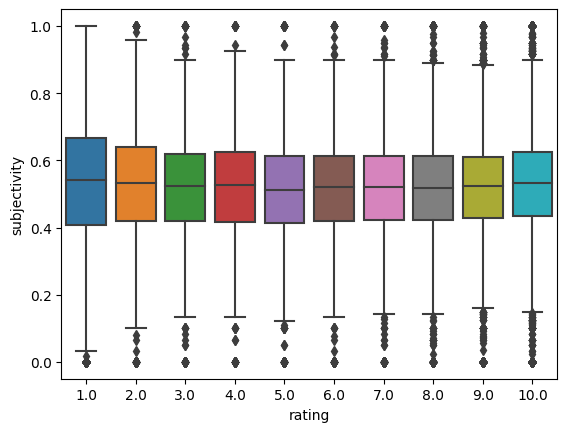

In [96]:
# How do subjectivity and polarity correlate with ratings? 
sns.boxplot(data=df, x='rating', y='subjectivity')
plt.show()

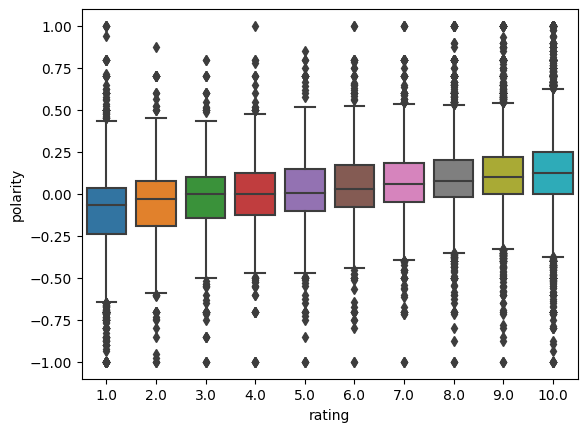

In [97]:
sns.boxplot(data=df, x='rating', y='polarity')
plt.show()

It appears that subjectivity doesn't vary too greatly, but polarity does clearly correlate with rating. 

I read somewhere that sentiment analysis actually does better with uncleaned data. Will I get a stronger correlation between polarity and rating if taking the polarity of the original review column?

In [98]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['original_polarity'] = df['review'].apply(get_polarity)
df.head()

,rating,condition,review,date,drug0,drug1,drug2,drug3,drug4,drug5,...,drug15,review_len,complexity,spell_corr,no_stops_lemm,lemm_len,no_stop_cap_lemm,subjectivity,polarity,original_polarity
0,9.0,add,I had began taking 20mg of Vyvanse for three m...,NaN,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,793,10.4,I had began taking 20mg of Vyvanse for three m...,begin take 20 mg Vyvanse month surprised find ...,453,begin take 20 mg vyvanse month surprised find ...,0.461111,0.061111,0.039286
1,8.0,add,Switched from Adderall to Dexedrine to compare...,NaN,dextroamphetamine,NaN,NaN,NaN,NaN,NaN,...,NaN,795,8.0,Twitched from Adderall to Dexedrine to compare...,twitch Adderall Dexedoctorine compare effect D...,546,twitch adderall dexedoctorine compare effect d...,0.501837,0.074949,0.140464
2,8.0,adhd,I have only been on Vyvanse for 2 weeks I sta...,NaN,vyvanse,NaN,NaN,NaN,NaN,NaN,...,NaN,446,2.9,I have only been on Vyvanse for 2 weeks I sta...,Vyvanse 2 week start 40 60 week probably upper...,243,vyvanse 2 week start 40 60 week probably upper...,0.241667,0.087500,0.010667
3,8.0,fatigue,1 subcutaneous injection of somatropin in abdo...,NaN,saizen,NaN,NaN,NaN,NaN,NaN,...,NaN,508,14.1,1 subcutaneous injection of somatropin in abdo...,1 subcutaneous injection somatropin abdoman in...,320,1 subcutaneous injection somatropin abdoman in...,0.348810,0.242857,0.320000
4,3.0,dementia,Since many of these ss are also ss of the dise...,NaN,zyprexa,NaN,NaN,NaN,NaN,NaN,...,NaN,417,11.5,Since many of these is are also is of the dise...,many diseaseLewy body Syndoctorome Dementia ta...,242,many diseaselewy body syndoctorome dementia ta...,0.466667,0.191667,0.000000


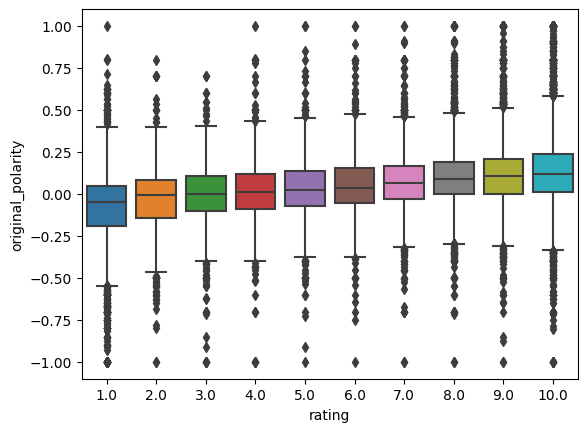

In [99]:
# View relationship of original polarity with ratings
sns.boxplot(data=df, x='rating', y='original_polarity')
plt.show()

At first glance, this doesn't look especially different from the variation of polarity with ratings when based on cleaner, lemmatized text. But I can get clearer on correlation of various variables with ratings by calculating it mathematically and visualizing that. 

Before visualizing relationships of variables with ratings, clean up the data. For example, when I created new columns for the multiple drugs that a review might be applicable to, most of the columns have barely any drugs present. Drop those. 

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31559 non-null  float64
 1   condition          31559 non-null  object 
 2   review             31559 non-null  object 
 3   date               31451 non-null  object 
 4   drug0              31559 non-null  object 
 5   drug1              18992 non-null  object 
 6   drug2              32 non-null     object 
 7   drug3              23 non-null     object 
 8   drug4              12 non-null     object 
 9   drug5              11 non-null     object 
 10  drug6              7 non-null      object 
 11  drug7              5 non-null      object 
 12  drug8              3 non-null      object 
 13  drug9              2 non-null      object 
 14  drug10             2 non-null      object 
 15  drug11             2 non-null      object 
 16  drug12             2 n

In [101]:
# drop columns drug2:15; these each have less than 1% of values present
# Also drop the lemm_len column and just keep the review_len column. 

df = df.drop(columns=['drug2', 'drug3', 'drug4', 'drug5', 'drug6', 'drug7', 'drug8', 'drug9', 
                      'drug10', 'drug11', 'drug12', 'drug13', 'drug14', 'drug15', 'lemm_len'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31559 non-null  float64
 1   condition          31559 non-null  object 
 2   review             31559 non-null  object 
 3   date               31451 non-null  object 
 4   drug0              31559 non-null  object 
 5   drug1              18992 non-null  object 
 6   review_len         31559 non-null  int64  
 7   complexity         31559 non-null  float64
 8   spell_corr         31559 non-null  object 
 9   no_stops_lemm      31559 non-null  object 
 10  no_stop_cap_lemm   31559 non-null  object 
 11  subjectivity       31559 non-null  float64
 12  polarity           31559 non-null  float64
 13  original_polarity  31559 non-null  float64
dtypes: float64(5), int64(1), object(8)
memory usage: 3.4+ MB


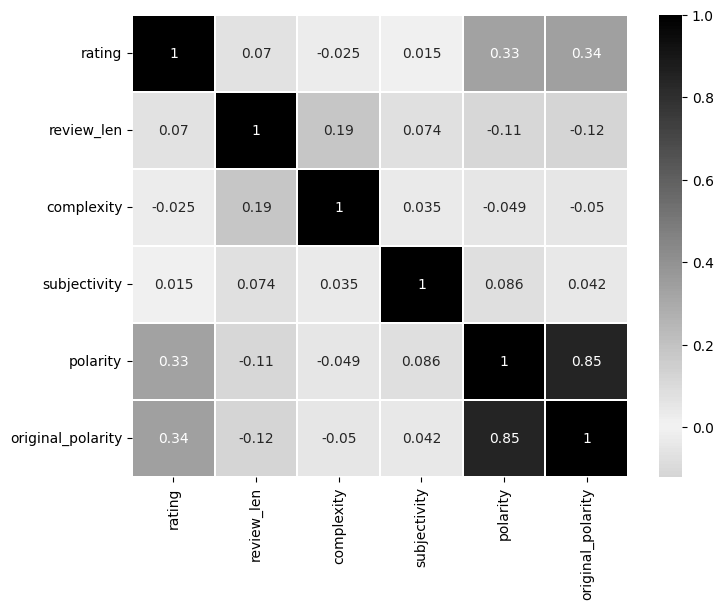

In [102]:
# Visualize correlations between numeric variables. 
plt.figure(figsize=(8,6))
cmap = sns.diverging_palette(h_neg=0, h_pos=0, s=0, l=0, as_cmap=True)
sns.heatmap(df[['rating', 'review_len', 'complexity', 'subjectivity', 'polarity', 
                'original_polarity']].corr(), linewidths=.1, cmap=cmap, center=0.0, annot=True)
plt.yticks(rotation=0);

In [103]:
# Remove the 'polarity' column so as not to have variables correlated with each other. 
df = df.drop(columns=['polarity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31559 non-null  float64
 1   condition          31559 non-null  object 
 2   review             31559 non-null  object 
 3   date               31451 non-null  object 
 4   drug0              31559 non-null  object 
 5   drug1              18992 non-null  object 
 6   review_len         31559 non-null  int64  
 7   complexity         31559 non-null  float64
 8   spell_corr         31559 non-null  object 
 9   no_stops_lemm      31559 non-null  object 
 10  no_stop_cap_lemm   31559 non-null  object 
 11  subjectivity       31559 non-null  float64
 12  original_polarity  31559 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 3.1+ MB


In [104]:
# Check out the data using describe. 
df.describe()

,rating,review_len,complexity,subjectivity,original_polarity
count,31559.000000,31559.000000,31559.000000,31559.000000,31559.000000
mean,7.424855,473.518141,6.197402,0.515616,0.083929
std,3.067194,248.035664,3.770265,0.188800,0.216392
min,1.000000,7.000000,-3.500000,0.000000,-1.000000
25%,6.000000,269.000000,4.300000,0.425587,-0.025000
50%,9.000000,479.000000,5.800000,0.527143,0.075000
75%,10.000000,713.000000,7.400000,0.623333,0.191157
max,10.000000,6196.000000,62.500000,1.000000,1.000000


My assumptions based upon visual inspection were correct. Polarity is very slightly more correlated with ratings than polarity of the lemmatized text, and polarity is much more correlated with rating than any other numeric variables. 

The average polarity score of all these reviews is 0.08. It makese sense that the average polarity is positive, since ratings skew high. I am slightly surprised, though, that the average polarity isn't even higher, since the average rating is about 8, dramatically skewed toward perfect. Apparently people will give a drug a perfect rating without writing an effusively positive review. 

The final step in preprocessing is selecting a method with which to engineer features directly from the content of the reviews, probably from the cleanest no_stop_cap_lemm column. I'll do that here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/6-kl-studies-finish-preprocess.ipynb

Note: I used these resources as references for some of the code in this notebook and would like to return to them again in the future:
- Drew lots of tips from this article. Still especially interested in digging deeper with visualizing word embeddings: https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b
- Contains code for efficiently creating list of ngrams with their frquency, wish I'd read this before doing what I did above: https://www.kaggle.com/code/sainathkrothapalli/nlp-visualisation-guide    

In [105]:
df.to_csv('../data/interim/studies_w_sentiment.csv')